## 0 - Pull in dependencies and initiate Duet session

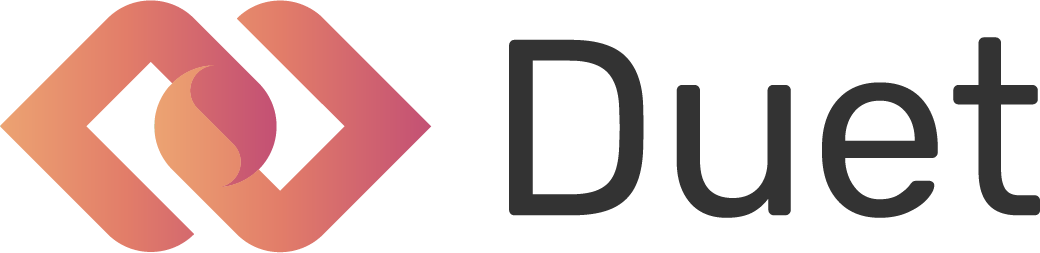

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [2]:
# First lets pull in our dependencies and initiate our duet session
import torch
import random
from torch import nn
from torch import optim
import syft as sy

duet = sy.join_duet(loopback=True)

## 1 - Define and send our remote assets

Here we'll define the remote model which will have the remote input data fed into it. This includes;

- Our first model segment
- Our dummy input data

In [3]:
from torchvision import datasets
from torchvision import transforms

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
# valset = datasets.MNIST('mnist', download=True, train=False, transform=transform)

labels = trainset.targets[:5000]
data = duet.store[0]
labels.shape

torch.Size([5000])

In [4]:
dataloader = duet.torch.utils.data.DataLoader(data, batch_size=128)
targetloader = torch.utils.data.DataLoader(labels, batch_size=128)

In [ ]:
input_size = 784
hidden_sizes = [128, 500]
output_size = 10

class SyNet_client(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet_client, self).__init__(torch_ref=torch_ref)
        self.lin = nn.Linear(input_size, hidden_sizes[0])
        
    def forward(self, x):
        x = self.lin(x)
        x = self.torch_ref.nn.functional.relu(x)
        return x
    
class SyNet_server(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet_server, self).__init__(torch_ref=torch_ref)
        self.lin2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lin3 = nn.Linear(hidden_sizes[1], output_size)
        self.sft = nn.LogSoftmax(dim=1) 
        
    def forward(self, x):
        x = self.lin2(x)
        x = nn.ReLU()(x)
        x = self.lin3(x)
        x = self.sft(x)
        return x

In [ ]:
#Model 1
model1 = SyNet_client(torch)
model1_ptr = model1.send(duet)
opt1 = duet.torch.optim.SGD(params=model1_ptr.parameters(),lr=0.01)

#Model 2
model2 = SyNet_server(torch)
opt2 = torch.optim.SGD(params=model2.parameters(),lr=0.1)

## 3 - Define our training logic

In [13]:
for images, target in zip(dataloader, targetloader):
    opt1.zero_grad()
    opt2.zero_grad()
    
    print(target.type)
    
    activation_ptr = model1_ptr(images)
    activation = activation_ptr.clone().get(request_block=True)
    
    pred = model2(activation)
    
    criterion = nn.NLLLoss()
#     print(pred)
    loss = criterion(pred, target.long())
    
#     train_correct += pred.max(1)[1].eq(target).sum().item()
#     train_total += pred.shape[0]
#     print(loss)
    
    loss.backward()
    grad_ptr = activation.grad.clone().send(duet)
    activation_ptr.backward(grad_ptr)
    
    opt1.step()
    opt2.step()
    print(loss)

AttributeError: 'NoneType' object has no attribute 'retain_grad'

## 4 - Pull in our Test Set

In [ ]:
test_kwargs = {
    "batch_size": args["test_batch_size"],
}

test_data = torchvision.datasets.MNIST('../data', train=False, download=True, transform=local_transforms)
test_loader = torch.utils.data.DataLoader(test_data,**train_kwargs)

In [ ]:
model1 = model1_ptr.get(request_block=True, reason="run testing ont the model")

## 5 - Test our Model

In [ ]:
# test_data_length = len(test_loader.dataset)
# test_batches = round((test_data_length / args["test_batch_size"]) + 0.5)
# test_loss = 0.0
# correct = 0.0
    
# for batch_idx, (data, target) in enumerate(test_loader):
#     output = model2(model1(data))
#     iter_loss = torch.nn.functional.nll_loss(output, target, reduction="sum").item()
#     test_loss = test_loss + iter_loss
#     pred = output.argmax(dim=1)
#     total = pred.eq(target).sum().item()
#     correct += total
            
#     if batch_idx >= test_batches - 1:
#                 print("batch_idx >= test_batches, breaking")
#                 break
#     accuracy = correct / test_data_length
#     print(f"Test Set Accuracy: {test_loss}%")